<a href="https://colab.research.google.com/github/SumitMohan/Covid-19-Vaccine/blob/main/Covid_19_Vaccine_LDA_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> **Topic Modeling through LDA(Latent Dirichlet Allocation) of Covid-19 Tweets**



In [ ]:
!pip install PyDrive
!pip install gensim
#!pip install pyldavis
!python -m spacy download en

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import nltk
from nltk import FreqDist
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
!pip install pyLDAvis==3.2.2

In [5]:
import pandas as pd
#pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy

import gensim
from gensim import corpora

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [6]:
df=pd.read_csv('Vaccine Tweets1.csv')
print(df.head(5))

   Unnamed: 0                                           TextBlob
0           0    mmpadellan pfizer literally millions doses v...
1           1    rmayemsinger rupe  murdoch fox news called c...
2           2             telushk get vaccine turn horse oh well
3           3    stevenbeschloss argument pence get vaccine e...
4           4    mollyjongfast rupe  murdoch got covid vaccin...


In [7]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [8]:

df.shape

(1432, 2)

In [9]:
def freq_words(x, terms = 10):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

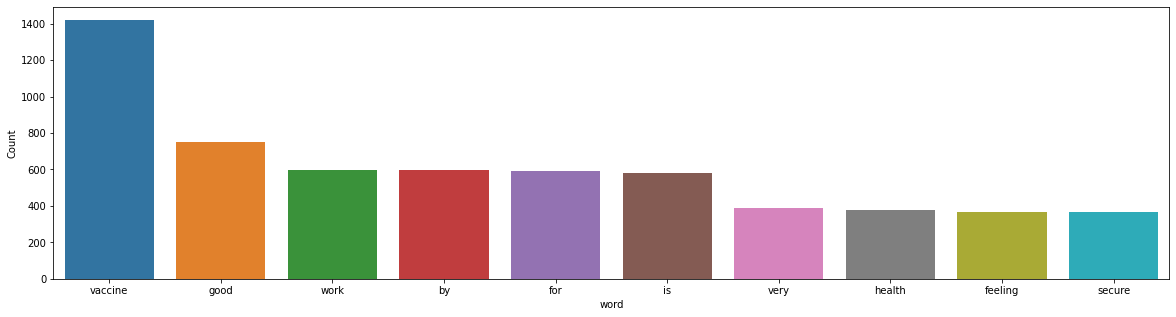

In [10]:
freq_words(df['TextBlob'])

In [11]:
# replace "n't" with " not"
df['TextBlob'] = df['TextBlob'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols
df['TextBlob'] = df['TextBlob'].str.replace("[^a-zA-Z#]", " ")

In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [13]:
# function to remove stopwords
def remove_stopwords(rev):
  rev_new = " ".join([i for i in rev if i not in stop_words])
  return rev_new

In [14]:
# remove short words (length < 2)
df['TextBlob'] = df['TextBlob'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# remove stopwords from the text
tweets = [remove_stopwords(r.split()) for r in df['TextBlob']]

# make entire text lowercase
tweets = [r.lower() for r in tweets]

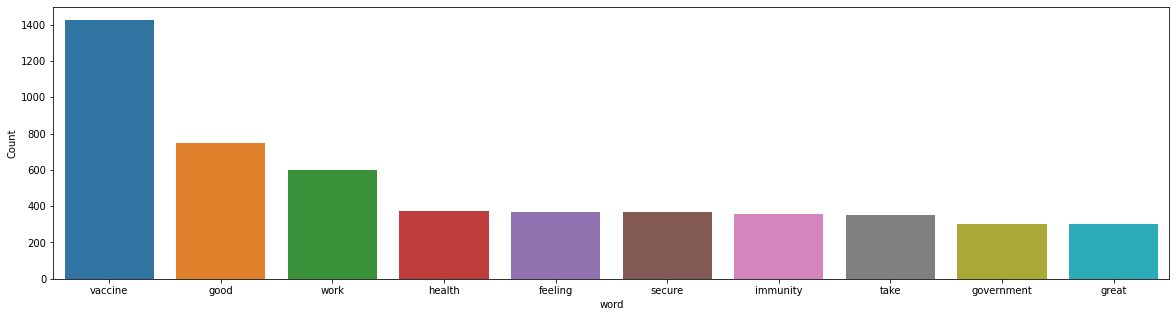

In [15]:
freq_words(tweets, 10)

In [16]:
nlp = spacy.load('en', disable=['parser', 'ner'])

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


In [17]:
def lemmatization(texts, tags=['NOUN', 'ADJ']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

In [18]:
tokenized_tweets = pd.Series(tweets).apply(lambda x: x.split())
print(tokenized_tweets[1])

['rmayemsinger', 'rupe', 'murdoch', 'fox', 'news', 'called', 'covid', 'hoax', 'running', 'loop', 'helping', 'kill', 'americans', 'today', 'rupe', 'got', 'thaeur']


In [19]:
print(tokenized_tweets[1])
len(tokenized_tweets[1])

['rmayemsinger', 'rupe', 'murdoch', 'fox', 'news', 'called', 'covid', 'hoax', 'running', 'loop', 'helping', 'kill', 'americans', 'today', 'rupe', 'got', 'thaeur']


17

In [ ]:
tweets_2 = lemmatization(tokenized_tweets)
print(tweets_2[1])

In [21]:
print(tweets_2[3])
len(tweets_2[3])

['argument', 'penny', 'vaccine', 'early', 'help', 'continuity', 'government', 'deadly', 'failureaeur']


9

In [22]:
set(tokenized_tweets[1]) - set(tweets_2[1])

{'americans',
 'called',
 'covid',
 'fox',
 'got',
 'helping',
 'hoax',
 'kill',
 'loop',
 'murdoch',
 'news',
 'rmayemsinger',
 'running'}

In [23]:
tweets_3 = []
for i in range(len(tweets_2)):
    tweets_3.append(' '.join(tweets_2[i]))
    
df['tweets'] = tweets_3

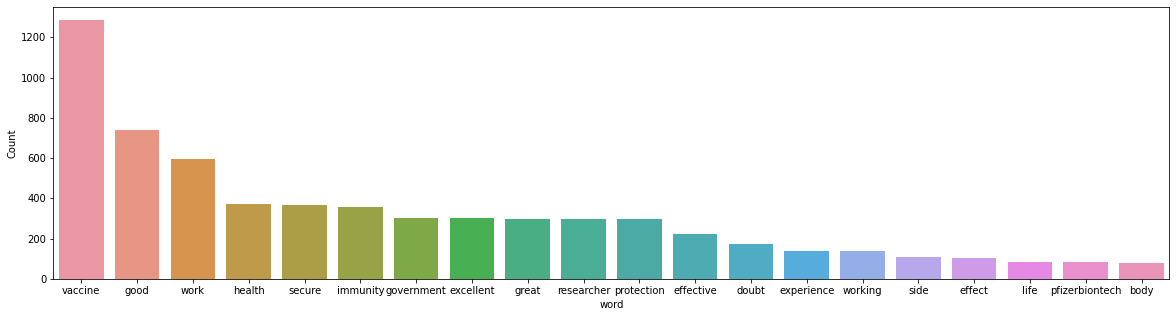

In [24]:
freq_words(df['tweets'], 20)

In [25]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(tweets_2)

In [26]:
# Convert list of tweets (tweets_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tweets_2]

In [27]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

In [ ]:
# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=3, 
                random_state=100,
                chunksize=50,
                passes=50)

In [29]:
lda_model.print_topics()

[(0,
  '0.071*"body" + 0.053*"health" + 0.044*"issue" + 0.035*"fever" + 0.035*"pain" + 0.034*"vccine" + 0.034*"bad" + 0.034*"temporary" + 0.022*"https" + 0.019*"perfect"'),
 (1,
  '0.111*"vaccine" + 0.073*"side" + 0.067*"effect" + 0.050*"pfizerbiontech" + 0.046*"covid" + 0.038*"doubt" + 0.036*"family" + 0.035*"member" + 0.035*"harmful" + 0.034*"experience"'),
 (2,
  '0.153*"work" + 0.121*"good" + 0.113*"vaccine" + 0.079*"immunity" + 0.078*"government" + 0.077*"researcher" + 0.076*"excellent" + 0.076*"great" + 0.076*"protection" + 0.076*"health"')]

In [30]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.342259  0.028072       1        1  59.235529
1      0.141517 -0.257375       2        1  25.434868
0      0.200742  0.229303       3        1  15.329603, topic_info=          Term        Freq       Total Category  logprob  loglift
442       work  731.000000  731.000000  Default  30.0000  30.0000
145       good  579.000000  579.000000  Default  29.0000  29.0000
101       side  151.000000  151.000000  Default  28.0000  28.0000
285   immunity  379.000000  379.000000  Default  27.0000  27.0000
4      vaccine  770.000000  770.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
656  emotional    6.110214    6.883534   Topic3  -5.3118   1.7562
657  firstaeur    6.110214    6.883534   Topic3  -5.3118   1.7562
427     market    5.060956    5.666940   Topic3  -5.5002   1.7623
26       https   26.893856   63.296508   Topic3  -3.8299   1.0195
60      health   65.108264  429.402470   Topic3  -2.9457  -0.0110

[149 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
316       1  0.869942   advisor
312       3  0.960231  allergic
333       2  0.846748       amp
250       3  0.970740  approval
391       3  0.920131      area
...     ...       ...       ...
426       3  0.117061    worker
361       2  0.988176   working
58        2  0.895692      year
58        3  0.127956      year
623       2  0.670406    yhycly

[112 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [31]:
# Print the Keyword in the 10 topics
lda_model.print_topics()

[(0,
  '0.071*"body" + 0.053*"health" + 0.044*"issue" + 0.035*"fever" + 0.035*"pain" + 0.034*"vccine" + 0.034*"bad" + 0.034*"temporary" + 0.022*"https" + 0.019*"perfect"'),
 (1,
  '0.111*"vaccine" + 0.073*"side" + 0.067*"effect" + 0.050*"pfizerbiontech" + 0.046*"covid" + 0.038*"doubt" + 0.036*"family" + 0.035*"member" + 0.035*"harmful" + 0.034*"experience"'),
 (2,
  '0.153*"work" + 0.121*"good" + 0.113*"vaccine" + 0.079*"immunity" + 0.078*"government" + 0.077*"researcher" + 0.076*"excellent" + 0.076*"great" + 0.076*"protection" + 0.076*"health"')]

In [32]:
#creating wordcloud 
from wordcloud import WordCloud  
WordCloud
from  nltk.corpus import stopwords #for stopwords 

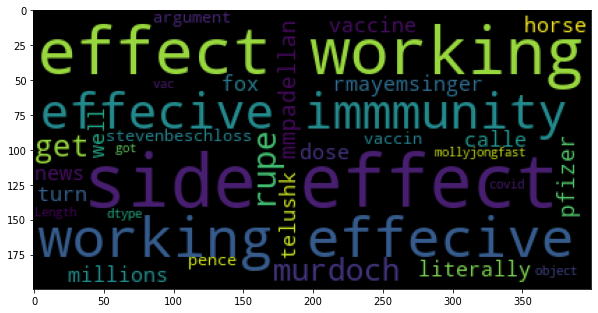

In [33]:
cloud  = WordCloud(max_words= 50, stopwords=stopwords.words("english") ).generate(str(tokenized_tweets) )
plt.figure(figsize= (10 , 10)) 
plt.imshow(cloud)